In [1]:
%matplotlib inline
import pandas as pd
from os.path import join as opj
from nipype.interfaces.io import DataSink
from nipype.interfaces.spm import (TwoSampleTTestDesign, EstimateModel,
                                   EstimateContrast)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

Failed to import duecredit due to No module named 'duecredit'
/home/zohyos7/anaconda3/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


In [2]:
political_profile = pd.read_csv("/data/wellbeing_bids/subj_profile.tsv",delimiter='\t',encoding='utf-8')

In [3]:
import pickle
with open("/home/zohyos7/republicans_tom.txt", "rb") as fp:
    republicans = pickle.load(fp)
with open("/home/zohyos7/democrats_tom.txt", "rb") as fp:
    democrats = pickle.load(fp)

In [5]:
len(republicans)

47

In [6]:
len(democrats)

55

In [7]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [8]:
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

mask = "/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# TwoSampleTTestDesign - creates two sample T-Test Design
twosamplettestdes = Node(TwoSampleTTestDesign(),
                         name="twosampttestdes")

twosamplettestdes.inputs.group1_files = ['/data/wellbeing_analysis/datasink/antsflow/sub-%s/con/task-tom/fwhm-8/con_0004_trans.nii' % (rep)
                                         for rep in republicans]
twosamplettestdes.inputs.group2_files = ['/data/wellbeing_analysis/datasink/antsflow/sub-%s/con/task-tom/fwhm-8/con_0004_trans.nii' % (dem)
                                         for dem in democrats]

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Republicans', 'T', ['Group_{1}'], [1]]
cont2 = ['Democrats', 'T', ['Group_{2}'], [1]]
cont3 = ['Republicans > Democrats', 'T', ['Group_{1}','Group_{2}'], [1, -1]]
cont4 = ['Democrats > Republicans', 'T', ['Group_{1}','Group_{2}'], [-1, 1]]
level2conestimate.inputs.contrasts = [cont1, cont2, cont3, cont4]

# save data
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")



In [9]:
# Initiation of the 2nd-level analysis workflow
BL_two_sample = Workflow(name='BL_two_sample')
BL_two_sample.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
BL_two_sample.connect([(gunzip, twosamplettestdes, [('out_file','explicit_mask_file')]),
                    (twosamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2estimate, datasink, [('mask_image',
                                                 'BL_two_sample.@mask')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    'BL_two_sample.@spm_mat'),
                                                   ('spmT_images',
                                                    'BL_two_sample.@T'),
                                                   ('con_images',
                                                    'BL_two_sample.@con')])
                   ])



181114-13:35:26,429 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/BL_two_sample/graph.png (graph2use=colored, simple_form=True).


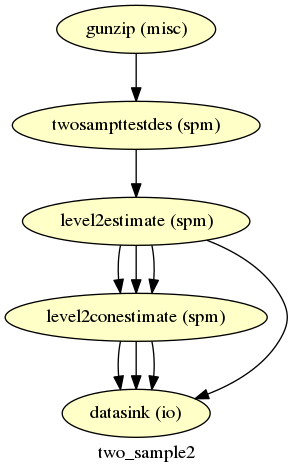

In [10]:
# Create 1st-level analysis output graph
BL_two_sample.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(BL_two_sample.base_dir, 'BL_two_sample', 'graph.png'))

In [12]:
BL_two_sample.run('MultiProc', plugin_args={'n_procs': 8})

181114-13:35:46,50 nipype.workflow INFO:
	 Workflow BL_two_sample settings: ['check', 'execution', 'logging', 'monitoring']
181114-13:35:46,65 nipype.workflow INFO:
	 Running in parallel.
181114-13:35:46,69 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
181114-13:35:46,252 nipype.workflow INFO:
	 [Node] Setting-up "BL_two_sample.gunzip" in "/data/wellbeing_analysis/workingdir/BL_two_sample/gunzip".
181114-13:35:46,265 nipype.workflow INFO:
	 [Node] Running "gunzip" ("nipype.algorithms.misc.Gunzip")
181114-13:35:46,388 nipype.workflow INFO:
	 [Node] Finished "BL_two_sample.gunzip".
181114-13:35:48,72 nipype.workflow INFO:
	 [Job 0] Completed (BL_two_sample.gunzip).
181114-13:35:48,79 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
181114-13:35:48,247 nipype.workflow INFO:
	 [Node] Setting-up "BL_two_sample.twosampttestdes" in "/data

In [55]:
from nilearn.plotting import (plot_stat_map, plot_img)
%matplotlib inline
anatimg = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

## Analyzed with only previously used subjects

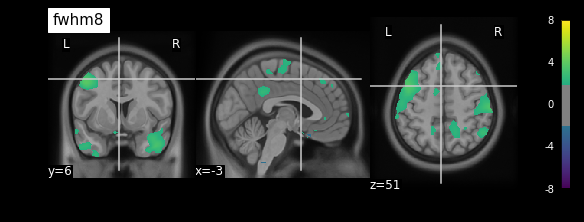

In [39]:
plot_stat_map(
    '/data/wellbeing_analysis/datasink/two_sample/task_tom/con04/spmT_0004.nii', title='fwhm8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='ortho', cut_coords=(-3, 6, 51), cmap='viridis');

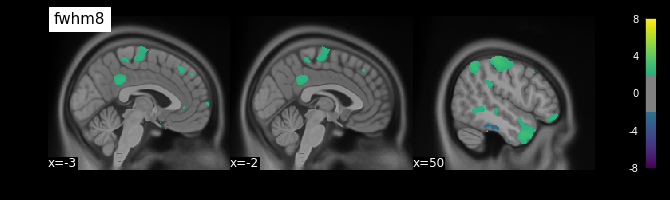

In [40]:
plot_stat_map(
    '/data/wellbeing_analysis/datasink/two_sample/task_tom/con04/spmT_0004.nii', title='fwhm8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='x', cut_coords=(-2, -3 ,50), cmap='viridis');

## Analyzed with more subjects (after checking mask image)

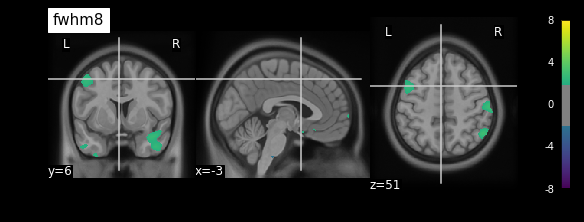

In [52]:
plot_stat_map(
    '/data/wellbeing_analysis/datasink/two_sample2/task_tom/con04/spmT_0004.nii', title='fwhm8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='ortho', cut_coords=(-3, 6, 51), cmap='viridis');

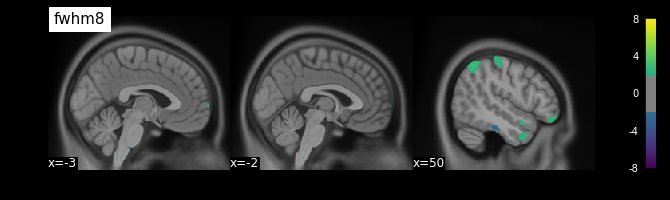

In [53]:
plot_stat_map(
    '/data/wellbeing_analysis/datasink/two_sample2/task_tom/con04/spmT_0004.nii', title='fwhm8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='x', cut_coords=(-2, -3 ,50), cmap='viridis');

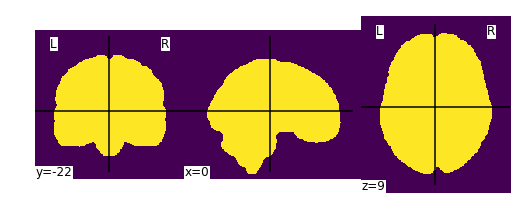

In [56]:
plot_img(
'/data/wellbeing_analysis/datasink/two_sample2/task_tom/con04/mask.nii')